In [2]:
import gymnasium as gym
import numpy as np
import torch
import open3d as o3d
from gymnasium import spaces
import copy
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [34]:
class ObjCoverageEnv(gym.Env):
    def __init__(self, obj_file_path, radius=20.0, coverage_threshold=0.98):
        super(ObjCoverageEnv, self).__init__()

        self.mesh = o3d.io.read_triangle_mesh(obj_file_path)
        self.mesh.compute_vertex_normals()
        
        self.vertices = torch.tensor(np.asarray(self.mesh.vertices), dtype=torch.float32).cuda()
        self.faces = torch.tensor(np.asarray(self.mesh.triangles), dtype=torch.int64).cuda()
        self.normals = torch.tensor(np.asarray(self.mesh.vertex_normals), dtype=torch.float32).cuda()
        
        self.num_faces = self.faces.shape[0]
        self.radius = radius
        self.coverage_threshold = coverage_threshold

        self.observation_space = spaces.Box(low=0, high=1, shape=(self.num_faces,), dtype=np.int8)
        self.action_space = spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)

        self.covered_faces = torch.zeros(self.num_faces, dtype=torch.bool).cuda()
        self.total_covered = 0
        self.steps = 0

        self.vis = o3d.visualization.Visualizer()
        self.vis.create_window(visible=False)
        self.vis.add_geometry(self.mesh)
        self.ctr = self.vis.get_view_control()
        self.camera = self.vis.get_view_control().convert_to_pinhole_camera_parameters()
        self.actions = []

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.covered_faces.fill_(False)
        self.total_covered = 0
        self.steps = 0
        return self._get_obs(), {}

    def step(self, action):
        self.last_action = action  # Store the last action for rendering
        self.actions.append(action)
        self.steps += 1
        # The agent currently is returning actions as a numpy, we convert them to GPU Tensors
        # TODO: Look into getting tensors directly from agent (entire process on GPU, not just the environment)
        action = torch.tensor(action, dtype=torch.float32).cuda()
        theta = (action[0] + 1) * np.pi
        phi = action[1] * np.pi / 2

        x = self.radius * torch.sin(theta) * torch.cos(phi)
        y = self.radius * torch.sin(theta) * torch.sin(phi)
        z = self.radius * torch.cos(theta)
        viewpoint = torch.tensor([x, y, z], dtype=torch.float32).cuda()

        face_centers = torch.mean(self.vertices[self.faces], dim=1)
        face_normals = torch.cross(self.vertices[self.faces[:, 1]] - self.vertices[self.faces[:, 0]],
                                   self.vertices[self.faces[:, 2]] - self.vertices[self.faces[:, 0]])
        face_normals = face_normals / torch.norm(face_normals, dim=1, keepdim=True)

        view_directions = face_centers - viewpoint
        view_directions = view_directions / torch.norm(view_directions, dim=1, keepdim=True)

        visible_faces = torch.sum(face_normals * view_directions, dim=1) < 0

        newly_covered = visible_faces & ~self.covered_faces
        self.covered_faces |= visible_faces
        self.total_covered = torch.sum(self.covered_faces).item()

        coverage = self.total_covered / self.num_faces
        reward = torch.sum(newly_covered).item() * 0.1
        if coverage >= self.coverage_threshold:
            reward += 10
        reward -= 0.01

        done = coverage >= self.coverage_threshold or self.steps >= 1000

        return self._get_obs(), reward, done, False, {}

    def _get_obs(self):
        return self.covered_faces.cpu().numpy()

    def render(self):
        # Create a new visualizer for each render call
        vis = o3d.visualization.Visualizer()
        vis.create_window()

        # Create a copy of the mesh for visualization
        vis_mesh = o3d.geometry.TriangleMesh()
        vis_mesh.vertices = o3d.utility.Vector3dVector(self.vertices.cpu().numpy())
        vis_mesh.triangles = o3d.utility.Vector3iVector(self.faces.cpu().numpy())

        # Color the mesh based on coverage
        colors = np.array([[0, 1, 0] if covered else [1, 0, 0] for covered in self.covered_faces.cpu().numpy()])
        vis_mesh.vertex_colors = o3d.utility.Vector3dVector(colors)

        # Add the mesh to the visualizer
        vis.add_geometry(vis_mesh)

        # Create a sphere to represent the viewpoint
        viewpoint = o3d.geometry.TriangleMesh.create_sphere(radius=1)
        viewpoint.compute_vertex_normals()
        viewpoint.paint_uniform_color([1, 0, 0])  # Blue color for viewpoint

        # Set the position of the viewpoint
        # Move last_action to CPU before using with numpy
        last_action_cpu = self.last_action.cpu().numpy()
        theta = (last_action_cpu[0] + 1) * np.pi
        phi = last_action_cpu[1] * np.pi / 2
        x = self.radius * np.sin(theta) * np.cos(phi)
        y = self.radius * np.sin(theta) * np.sin(phi)
        z = self.radius * np.cos(theta)
        viewpoint.translate([x, y, z])

        # # Add the viewpoint to the visualizer
        vis.add_geometry(viewpoint)
        # o3d.visualization.draw_geometries([viewpoint, vis_mesh])

        # # Set up the camera view
        ctr = vis.get_view_control()
        ctr.set_front([0, 0, -1])
        ctr.set_lookat([0, 0, 0])
        ctr.set_up([0, 1, 0])
        ctr.set_zoom(0.8)

        # # Update the geometry and render
        vis.update_geometry(vis_mesh)
        vis.update_geometry(viewpoint)
        vis.poll_events()
        vis.update_renderer()

        # Capture and display the image
        img = vis.capture_screen_float_buffer(do_render=True)
        vis.destroy_window()

        # Convert the image to numpy array and display using matplotlib
        plt.imshow(np.asarray(img))
        plt.title(f"Coverage: {self.total_covered / self.num_faces:.2%}")
        plt.axis('off')
        plt.show()


    def close(self):
        if hasattr(self, 'vis'):
            self.vis.destroy_window()

/tmp/ipykernel_16438/2406466168.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float32).cuda()


Idx:   0 | reward: 425.19000 | Done: done=False


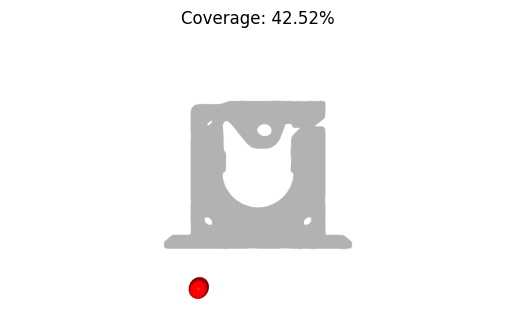

Idx:   1 | reward:  95.49000 | Done: done=False


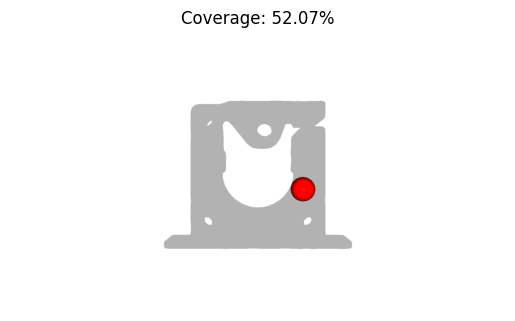

Idx:   2 | reward:  13.99000 | Done: done=False


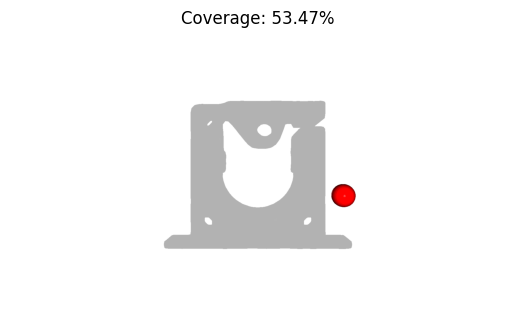

Idx:   3 | reward: 227.29000 | Done: done=False


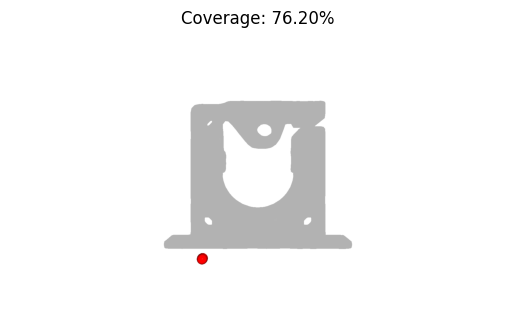

Idx:   4 | reward:  78.59000 | Done: done=False


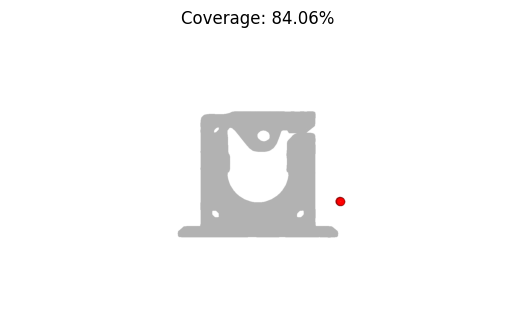

Idx:   5 | reward:   6.99000 | Done: done=False


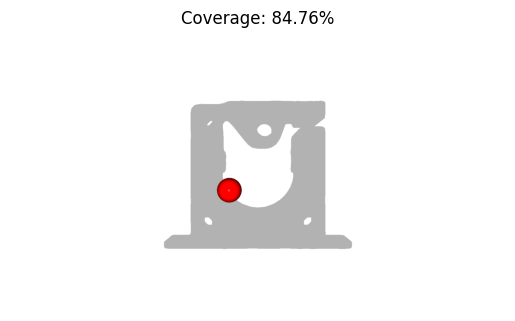

Idx:   6 | reward:  83.69000 | Done: done=False


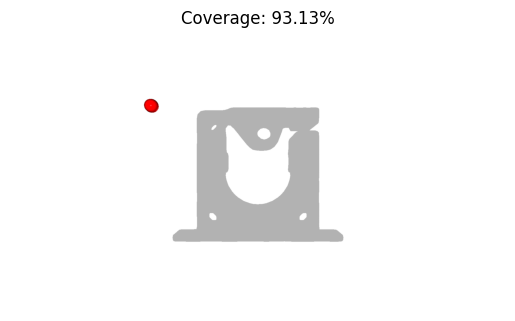

Idx:   7 | reward:  28.99000 | Done: done=False


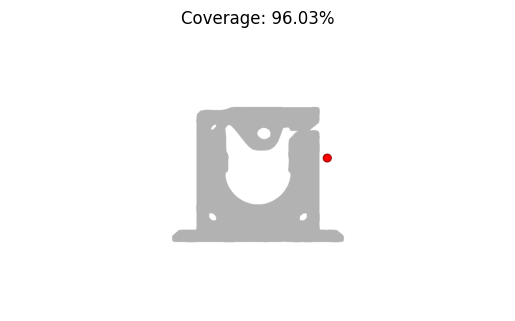

Idx:   8 | reward:   2.49000 | Done: done=False


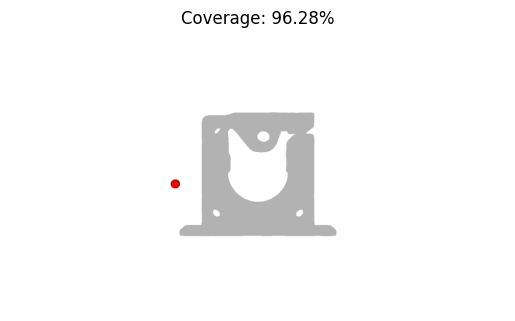

Idx:   9 | reward:   0.09000 | Done: done=False


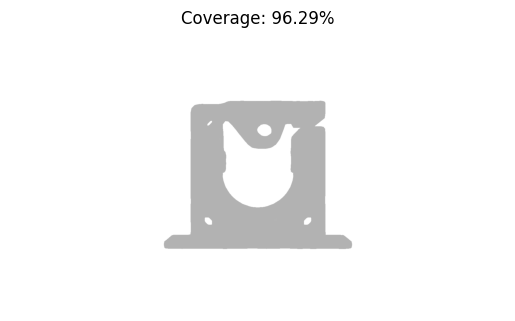

Idx:  10 | reward:  -0.01000 | Done: done=False


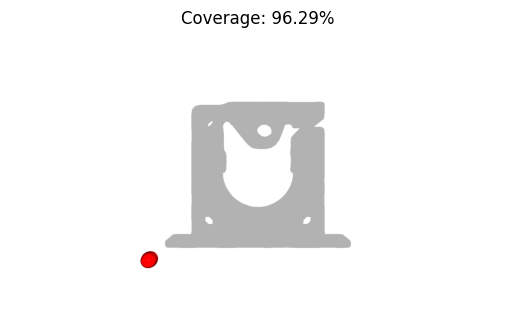

Idx:  11 | reward:   1.89000 | Done: done=False


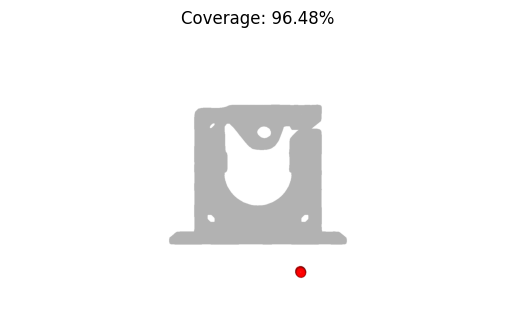

Idx:  12 | reward:  44.79000 | Done: done=True


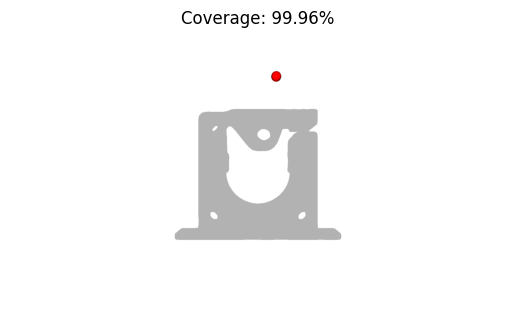

In [35]:
env = ObjCoverageEnv("/home/dir/RL_CoveragePlanning/test_models/modified/test_7.obj")
obs = env.reset()

for i in range(50):
    action = env.action_space.sample()
    action_tensor = torch.tensor(action, dtype=torch.float32).cuda()
    
    obs, reward, done, _, info = env.step(action_tensor)
    print(f"Idx: {i:3d} | reward: {reward:9.5f} | Done: {done=}")
    env.render()
    
    if done:
        break

In [40]:
actions = env.actions

vis_mesh = o3d.geometry.TriangleMesh()
vis_mesh.vertices = o3d.utility.Vector3dVector(env.vertices.cpu().numpy())
vis_mesh.triangles = o3d.utility.Vector3iVector(env.faces.cpu().numpy())

objects = [vis_mesh]

radius = env.radius

for action in actions:
    # Create a sphere to represent the viewpoint
    viewpoint = o3d.geometry.TriangleMesh.create_sphere(radius=0.5)
    viewpoint.compute_vertex_normals()
    viewpoint.paint_uniform_color([1, 0, 0])  # Blue color for viewpoint

    # Set the position of the viewpoint
    # Move last_action to CPU before using with numpy
    action_cpu = action.cpu().numpy()
    theta = (action_cpu[0] + 1) * np.pi
    phi = action_cpu[1] * np.pi / 2
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    viewpoint.translate([x, y, z])

    objects.append(viewpoint)

o3d.visualization.draw_geometries(objects, mesh_show_wireframe = False)

## Training a Sample Agent

In [6]:
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

2024-09-25 18:07:50.629006: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 18:07:50.630597: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 18:07:50.670326: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 18:07:51.148357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
env = ObjCoverageEnv("/home/dir/RL_CoveragePlanning/test_models/modified/test_7.obj")

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=int(2e5), progress_bar=True)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 455      |
| time/              |          |
|    fps             | 1291     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 1051         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0049784454 |
|    clip_fraction        | 0.0341       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | -0.00319     |
|    learning_rate        | 0.0003       |
|    loss                 | 66.4         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000781    |
|    std                  | 0.982        |
|    value_loss           | 307          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 1018        |
|    iterations           | 3           |
|    time_elapsed         | 6           |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.005242415 |
|    clip_fraction        | 0.0315      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.79       |
|    explained_variance   | 0.00541     |
|    learning_rate        | 0.0003      |
|    loss                 | 3.95        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.000478   |
|    std                  | 0.971       |
|    value_loss           | 202         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 1002         |
|    iterations           | 4            |
|    time_elapsed         | 8            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0058115255 |
|    clip_fraction        | 0.0103       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.77        |
|    explained_variance   | 0.0155       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0176       |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.000218    |
|    std                  | 0.964        |
|    value_loss           | 202          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 991          |
|    iterations           | 5            |
|    time_elapsed         | 10           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0016800095 |
|    clip_fraction        | 0.0184       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.75        |
|    explained_variance   | 0.022        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00773     |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.000486    |
|    std                  | 0.955        |
|    value_loss           | 201          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 987          |
|    iterations           | 6            |
|    time_elapsed         | 12           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0077572754 |
|    clip_fraction        | 0.0637       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.73        |
|    explained_variance   | 0.0319       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0436       |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00315     |
|    std                  | 0.944        |
|    value_loss           | 198          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 982         |
|    iterations           | 7           |
|    time_elapsed         | 14          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.002672261 |
|    clip_fraction        | 0.00908     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.72       |
|    explained_variance   | 0.0412      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.28        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.000741   |
|    std                  | 0.939       |
|    value_loss           | 200         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 977          |
|    iterations           | 8            |
|    time_elapsed         | 16           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0100079235 |
|    clip_fraction        | 0.0566       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.71        |
|    explained_variance   | 0.0636       |
|    learning_rate        | 0.0003       |
|    loss                 | 14.2         |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00258     |
|    std                  | 0.939        |
|    value_loss           | 198          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 974          |
|    iterations           | 9            |
|    time_elapsed         | 18           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0059524653 |
|    clip_fraction        | 0.0825       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.71        |
|    explained_variance   | 0.0653       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0123      |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.0033      |
|    std                  | 0.938        |
|    value_loss           | 198          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 971          |
|    iterations           | 10           |
|    time_elapsed         | 21           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0031955652 |
|    clip_fraction        | 0.0272       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.71        |
|    explained_variance   | 0.0796       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.112        |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.0011      |
|    std                  | 0.939        |
|    value_loss           | 193          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 968          |
|    iterations           | 11           |
|    time_elapsed         | 23           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0050776573 |
|    clip_fraction        | 0.056        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.71        |
|    explained_variance   | 0.107        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.22         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00278     |
|    std                  | 0.939        |
|    value_loss           | 190          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 966          |
|    iterations           | 12           |
|    time_elapsed         | 25           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0040614693 |
|    clip_fraction        | 0.0204       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.69        |
|    explained_variance   | 0.103        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00379     |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.000867    |
|    std                  | 0.921        |
|    value_loss           | 188          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 964         |
|    iterations           | 13          |
|    time_elapsed         | 27          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.006829815 |
|    clip_fraction        | 0.039       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | 0.124       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.583       |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00185    |
|    std                  | 0.902       |
|    value_loss           | 187         |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1e+03         |
|    ep_rew_mean          | 455           |
| time/                   |               |
|    fps                  | 961           |
|    iterations           | 14            |
|    time_elapsed         | 29            |
|    total_timesteps      | 28672         |
| train/                  |               |
|    approx_kl            | 0.00059134315 |
|    clip_fraction        | 0.00288       |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.63         |
|    explained_variance   | 0.145         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.103         |
|    n_updates            | 130           |
|    policy_gradient_loss | 0.000608      |
|    std                  | 0.902         |
|    value_loss           | 186           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 960          |
|    iterations           | 15           |
|    time_elapsed         | 31           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0034888117 |
|    clip_fraction        | 0.0546       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.61        |
|    explained_variance   | 0.153        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00423      |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.001       |
|    std                  | 0.886        |
|    value_loss           | 184          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 959         |
|    iterations           | 16          |
|    time_elapsed         | 34          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.006078888 |
|    clip_fraction        | 0.0622      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | 0.169       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.039       |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00307    |
|    std                  | 0.882       |
|    value_loss           | 179         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 957         |
|    iterations           | 17          |
|    time_elapsed         | 36          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.002183511 |
|    clip_fraction        | 0.0412      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | 0.162       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.221       |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00166    |
|    std                  | 0.883       |
|    value_loss           | 175         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 18           |
|    time_elapsed         | 38           |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0008956343 |
|    clip_fraction        | 0.00967      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.58        |
|    explained_variance   | 0.167        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.4e+03      |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.000944    |
|    std                  | 0.874        |
|    value_loss           | 176          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 957          |
|    iterations           | 19           |
|    time_elapsed         | 40           |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0023415284 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.56        |
|    explained_variance   | 0.19         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00607      |
|    n_updates            | 180          |
|    policy_gradient_loss | -6.85e-05    |
|    std                  | 0.867        |
|    value_loss           | 175          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 957          |
|    iterations           | 20           |
|    time_elapsed         | 42           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0038965764 |
|    clip_fraction        | 0.01         |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.55        |
|    explained_variance   | 0.193        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0163       |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00108     |
|    std                  | 0.869        |
|    value_loss           | 174          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 957         |
|    iterations           | 21          |
|    time_elapsed         | 44          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.003849804 |
|    clip_fraction        | 0.0188      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.55       |
|    explained_variance   | 0.201       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.38        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00271    |
|    std                  | 0.866       |
|    value_loss           | 171         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 22           |
|    time_elapsed         | 47           |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0068748975 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.54        |
|    explained_variance   | 0.203        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0462       |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00141     |
|    std                  | 0.861        |
|    value_loss           | 256          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 23           |
|    time_elapsed         | 49           |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0048195235 |
|    clip_fraction        | 0.0444       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.54        |
|    explained_variance   | 0.22         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00516      |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.000801    |
|    std                  | 0.859        |
|    value_loss           | 167          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 24          |
|    time_elapsed         | 51          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.000787152 |
|    clip_fraction        | 0.000879    |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | 0.222       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.703       |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.000441   |
|    std                  | 0.858       |
|    value_loss           | 166         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 25           |
|    time_elapsed         | 53           |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0056381547 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.53        |
|    explained_variance   | 0.21         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0236       |
|    n_updates            | 240          |
|    policy_gradient_loss | 0.000946     |
|    std                  | 0.855        |
|    value_loss           | 163          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 26          |
|    time_elapsed         | 55          |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.006513266 |
|    clip_fraction        | 0.034       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.52       |
|    explained_variance   | 0.214       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00198    |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.000943   |
|    std                  | 0.853       |
|    value_loss           | 160         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 27           |
|    time_elapsed         | 57           |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0027109156 |
|    clip_fraction        | 0.00728      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.51        |
|    explained_variance   | 0.244        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0229       |
|    n_updates            | 260          |
|    policy_gradient_loss | 0.000101     |
|    std                  | 0.846        |
|    value_loss           | 159          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 28          |
|    time_elapsed         | 59          |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.004661276 |
|    clip_fraction        | 0.0489      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.49       |
|    explained_variance   | 0.295       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0129      |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.000958   |
|    std                  | 0.836       |
|    value_loss           | 156         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 29           |
|    time_elapsed         | 62           |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0034864321 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.49        |
|    explained_variance   | 0.234        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.016        |
|    n_updates            | 280          |
|    policy_gradient_loss | -3.93e-05    |
|    std                  | 0.844        |
|    value_loss           | 164          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 30          |
|    time_elapsed         | 64          |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.005519373 |
|    clip_fraction        | 0.00874     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.49       |
|    explained_variance   | 0.274       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.136       |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.000249   |
|    std                  | 0.84        |
|    value_loss           | 159         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 31           |
|    time_elapsed         | 66           |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0037662033 |
|    clip_fraction        | 0.0221       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.49        |
|    explained_variance   | 0.262        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.03         |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00087     |
|    std                  | 0.839        |
|    value_loss           | 158          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 32           |
|    time_elapsed         | 68           |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0031729497 |
|    clip_fraction        | 0.0774       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.48        |
|    explained_variance   | 0.28         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00993      |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.00262     |
|    std                  | 0.835        |
|    value_loss           | 154          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 33           |
|    time_elapsed         | 70           |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0028908541 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.47        |
|    explained_variance   | 0.298        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0104       |
|    n_updates            | 320          |
|    policy_gradient_loss | 0.000498     |
|    std                  | 0.831        |
|    value_loss           | 154          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 34          |
|    time_elapsed         | 72          |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.004210378 |
|    clip_fraction        | 0.0677      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.46       |
|    explained_variance   | 0.279       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000481    |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0015     |
|    std                  | 0.821       |
|    value_loss           | 153         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 955         |
|    iterations           | 35          |
|    time_elapsed         | 74          |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.004873854 |
|    clip_fraction        | 0.013       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.44       |
|    explained_variance   | 0.295       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.014       |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00113    |
|    std                  | 0.819       |
|    value_loss           | 150         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 36           |
|    time_elapsed         | 77           |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0057461043 |
|    clip_fraction        | 0.0715       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.44        |
|    explained_variance   | 0.327        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.482        |
|    n_updates            | 350          |
|    policy_gradient_loss | 0.000355     |
|    std                  | 0.821        |
|    value_loss           | 148          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 37           |
|    time_elapsed         | 79           |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0012653181 |
|    clip_fraction        | 0.0214       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.45        |
|    explained_variance   | 0.294        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00502      |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.000377    |
|    std                  | 0.822        |
|    value_loss           | 154          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 38           |
|    time_elapsed         | 81           |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0003956941 |
|    clip_fraction        | 0.0082       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.45        |
|    explained_variance   | 0.291        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0233       |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.000185    |
|    std                  | 0.824        |
|    value_loss           | 154          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 955         |
|    iterations           | 39          |
|    time_elapsed         | 83          |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.004380598 |
|    clip_fraction        | 0.0215      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.44       |
|    explained_variance   | 0.296       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.324       |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.000156   |
|    std                  | 0.816       |
|    value_loss           | 149         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 955         |
|    iterations           | 40          |
|    time_elapsed         | 85          |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.005861331 |
|    clip_fraction        | 0.0698      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.43       |
|    explained_variance   | 0.3         |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0149     |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00206    |
|    std                  | 0.814       |
|    value_loss           | 145         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 455        |
| time/                   |            |
|    fps                  | 955        |
|    iterations           | 41         |
|    time_elapsed         | 87         |
|    total_timesteps      | 83968      |
| train/                  |            |
|    approx_kl            | 0.00897341 |
|    clip_fraction        | 0.0726     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.44      |
|    explained_variance   | 0.331      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.14e+03   |
|    n_updates            | 400        |
|    policy_gradient_loss | -0.0019    |
|    std                  | 0.819      |
|    value_loss           | 145        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 954          |
|    iterations           | 42           |
|    time_elapsed         | 90           |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0068418793 |
|    clip_fraction        | 0.0945       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.44        |
|    explained_variance   | 0.313        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0883       |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00031     |
|    std                  | 0.819        |
|    value_loss           | 141          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 43           |
|    time_elapsed         | 92           |
|    total_timesteps      | 88064        |
| train/                  |              |
|    approx_kl            | 0.0049565574 |
|    clip_fraction        | 0.0797       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.43        |
|    explained_variance   | 0.33         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0389       |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00141     |
|    std                  | 0.812        |
|    value_loss           | 215          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 955         |
|    iterations           | 44          |
|    time_elapsed         | 94          |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.002859211 |
|    clip_fraction        | 0.0061      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.42       |
|    explained_variance   | 0.361       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.26        |
|    n_updates            | 430         |
|    policy_gradient_loss | 0.000221    |
|    std                  | 0.812       |
|    value_loss           | 143         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 45           |
|    time_elapsed         | 96           |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0022130283 |
|    clip_fraction        | 0.0342       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.42        |
|    explained_variance   | 0.335        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.33         |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.000803    |
|    std                  | 0.809        |
|    value_loss           | 142          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 955         |
|    iterations           | 46          |
|    time_elapsed         | 98          |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.007437083 |
|    clip_fraction        | 0.0536      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.352       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0336      |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00182    |
|    std                  | 0.8         |
|    value_loss           | 139         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 955         |
|    iterations           | 47          |
|    time_elapsed         | 100         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.004452167 |
|    clip_fraction        | 0.0425      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.4        |
|    explained_variance   | 0.344       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.413       |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.000524   |
|    std                  | 0.803       |
|    value_loss           | 145         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 48           |
|    time_elapsed         | 102          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0040245354 |
|    clip_fraction        | 0.0208       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.4         |
|    explained_variance   | 0.375        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.528        |
|    n_updates            | 470          |
|    policy_gradient_loss | -9.99e-05    |
|    std                  | 0.801        |
|    value_loss           | 140          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 455        |
| time/                   |            |
|    fps                  | 957        |
|    iterations           | 49         |
|    time_elapsed         | 104        |
|    total_timesteps      | 100352     |
| train/                  |            |
|    approx_kl            | 0.00315839 |
|    clip_fraction        | 0.00654    |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.39      |
|    explained_variance   | 0.38       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.12       |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.000632  |
|    std                  | 0.801      |
|    value_loss           | 139        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 957         |
|    iterations           | 50          |
|    time_elapsed         | 106         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.006385286 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.357       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.159       |
|    n_updates            | 490         |
|    policy_gradient_loss | -5.67e-05   |
|    std                  | 0.797       |
|    value_loss           | 141         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 957         |
|    iterations           | 51          |
|    time_elapsed         | 109         |
|    total_timesteps      | 104448      |
| train/                  |             |
|    approx_kl            | 0.006532202 |
|    clip_fraction        | 0.02        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.38       |
|    explained_variance   | 0.401       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.365       |
|    n_updates            | 500         |
|    policy_gradient_loss | 0.000501    |
|    std                  | 0.798       |
|    value_loss           | 135         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 957          |
|    iterations           | 52           |
|    time_elapsed         | 111          |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0030571294 |
|    clip_fraction        | 0.0147       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.39        |
|    explained_variance   | 0.382        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.121        |
|    n_updates            | 510          |
|    policy_gradient_loss | -5.07e-05    |
|    std                  | 0.797        |
|    value_loss           | 137          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 958          |
|    iterations           | 53           |
|    time_elapsed         | 113          |
|    total_timesteps      | 108544       |
| train/                  |              |
|    approx_kl            | 0.0058313245 |
|    clip_fraction        | 0.0122       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.38        |
|    explained_variance   | 0.36         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0156       |
|    n_updates            | 520          |
|    policy_gradient_loss | -0.00152     |
|    std                  | 0.795        |
|    value_loss           | 139          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 958         |
|    iterations           | 54          |
|    time_elapsed         | 115         |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.003483561 |
|    clip_fraction        | 0.0188      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.38       |
|    explained_variance   | 0.416       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.404       |
|    n_updates            | 530         |
|    policy_gradient_loss | 0.000858    |
|    std                  | 0.797       |
|    value_loss           | 135         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 958         |
|    iterations           | 55          |
|    time_elapsed         | 117         |
|    total_timesteps      | 112640      |
| train/                  |             |
|    approx_kl            | 0.006658906 |
|    clip_fraction        | 0.043       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.372       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0392      |
|    n_updates            | 540         |
|    policy_gradient_loss | -0.000305   |
|    std                  | 0.798       |
|    value_loss           | 131         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 958         |
|    iterations           | 56          |
|    time_elapsed         | 119         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.006031491 |
|    clip_fraction        | 0.0428      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.37       |
|    explained_variance   | 0.409       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0227      |
|    n_updates            | 550         |
|    policy_gradient_loss | -0.00199    |
|    std                  | 0.791       |
|    value_loss           | 134         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 958         |
|    iterations           | 57          |
|    time_elapsed         | 121         |
|    total_timesteps      | 116736      |
| train/                  |             |
|    approx_kl            | 0.008119373 |
|    clip_fraction        | 0.0581      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | 0.403       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.55        |
|    n_updates            | 560         |
|    policy_gradient_loss | -9.86e-05   |
|    std                  | 0.79        |
|    value_loss           | 126         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 958          |
|    iterations           | 58           |
|    time_elapsed         | 123          |
|    total_timesteps      | 118784       |
| train/                  |              |
|    approx_kl            | 0.0052913437 |
|    clip_fraction        | 0.109        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.36        |
|    explained_variance   | 0.439        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0278       |
|    n_updates            | 570          |
|    policy_gradient_loss | 0.00104      |
|    std                  | 0.787        |
|    value_loss           | 123          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 958         |
|    iterations           | 59          |
|    time_elapsed         | 126         |
|    total_timesteps      | 120832      |
| train/                  |             |
|    approx_kl            | 0.005931816 |
|    clip_fraction        | 0.0466      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | 0.405       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.199       |
|    n_updates            | 580         |
|    policy_gradient_loss | 0.000627    |
|    std                  | 0.788       |
|    value_loss           | 127         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 958          |
|    iterations           | 60           |
|    time_elapsed         | 128          |
|    total_timesteps      | 122880       |
| train/                  |              |
|    approx_kl            | 0.0028342034 |
|    clip_fraction        | 0.0394       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.36        |
|    explained_variance   | 0.424        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.3         |
|    n_updates            | 590          |
|    policy_gradient_loss | 1.06e-05     |
|    std                  | 0.789        |
|    value_loss           | 130          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 455        |
| time/                   |            |
|    fps                  | 958        |
|    iterations           | 61         |
|    time_elapsed         | 130        |
|    total_timesteps      | 124928     |
| train/                  |            |
|    approx_kl            | 0.00412064 |
|    clip_fraction        | 0.0167     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.37      |
|    explained_variance   | 0.426      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0679     |
|    n_updates            | 600        |
|    policy_gradient_loss | -0.00111   |
|    std                  | 0.793      |
|    value_loss           | 129        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 958          |
|    iterations           | 62           |
|    time_elapsed         | 132          |
|    total_timesteps      | 126976       |
| train/                  |              |
|    approx_kl            | 0.0051678796 |
|    clip_fraction        | 0.0405       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.35        |
|    explained_variance   | 0.444        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00747      |
|    n_updates            | 610          |
|    policy_gradient_loss | 0.000505     |
|    std                  | 0.783        |
|    value_loss           | 123          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 958          |
|    iterations           | 63           |
|    time_elapsed         | 134          |
|    total_timesteps      | 129024       |
| train/                  |              |
|    approx_kl            | 0.0060478607 |
|    clip_fraction        | 0.0315       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.34        |
|    explained_variance   | 0.422        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000205    |
|    n_updates            | 620          |
|    policy_gradient_loss | -0.000721    |
|    std                  | 0.781        |
|    value_loss           | 123          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 958         |
|    iterations           | 64          |
|    time_elapsed         | 136         |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.002237101 |
|    clip_fraction        | 0.0159      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.33       |
|    explained_variance   | 0.453       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.1         |
|    n_updates            | 630         |
|    policy_gradient_loss | -0.000625   |
|    std                  | 0.777       |
|    value_loss           | 177         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 958          |
|    iterations           | 65           |
|    time_elapsed         | 138          |
|    total_timesteps      | 133120       |
| train/                  |              |
|    approx_kl            | 0.0049192095 |
|    clip_fraction        | 0.017        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.33        |
|    explained_variance   | 0.438        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.99         |
|    n_updates            | 640          |
|    policy_gradient_loss | 0.000677     |
|    std                  | 0.777        |
|    value_loss           | 122          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 957          |
|    iterations           | 66           |
|    time_elapsed         | 141          |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 0.0013059997 |
|    clip_fraction        | 0.0329       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.33        |
|    explained_variance   | 0.421        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.28         |
|    n_updates            | 650          |
|    policy_gradient_loss | 0.000583     |
|    std                  | 0.775        |
|    value_loss           | 123          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 957          |
|    iterations           | 67           |
|    time_elapsed         | 143          |
|    total_timesteps      | 137216       |
| train/                  |              |
|    approx_kl            | 0.0014099781 |
|    clip_fraction        | 0.0199       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.32        |
|    explained_variance   | 0.427        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.433        |
|    n_updates            | 660          |
|    policy_gradient_loss | -0.000169    |
|    std                  | 0.771        |
|    value_loss           | 116          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 957         |
|    iterations           | 68          |
|    time_elapsed         | 145         |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.010134401 |
|    clip_fraction        | 0.0856      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.31       |
|    explained_variance   | 0.429       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.443       |
|    n_updates            | 670         |
|    policy_gradient_loss | -1.61e-05   |
|    std                  | 0.765       |
|    value_loss           | 115         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 957          |
|    iterations           | 69           |
|    time_elapsed         | 147          |
|    total_timesteps      | 141312       |
| train/                  |              |
|    approx_kl            | 0.0051779663 |
|    clip_fraction        | 0.036        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.29        |
|    explained_variance   | 0.44         |
|    learning_rate        | 0.0003       |
|    loss                 | 4.55         |
|    n_updates            | 680          |
|    policy_gradient_loss | -0.000771    |
|    std                  | 0.763        |
|    value_loss           | 115          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 957         |
|    iterations           | 70          |
|    time_elapsed         | 149         |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.004667836 |
|    clip_fraction        | 0.0916      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.29       |
|    explained_variance   | 0.443       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.462       |
|    n_updates            | 690         |
|    policy_gradient_loss | -0.00249    |
|    std                  | 0.763       |
|    value_loss           | 122         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 957         |
|    iterations           | 71          |
|    time_elapsed         | 151         |
|    total_timesteps      | 145408      |
| train/                  |             |
|    approx_kl            | 0.008117829 |
|    clip_fraction        | 0.0575      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.28       |
|    explained_variance   | 0.477       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.08        |
|    n_updates            | 700         |
|    policy_gradient_loss | -0.00055    |
|    std                  | 0.758       |
|    value_loss           | 117         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 72          |
|    time_elapsed         | 154         |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.007107646 |
|    clip_fraction        | 0.0372      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.27       |
|    explained_variance   | 0.459       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0491      |
|    n_updates            | 710         |
|    policy_gradient_loss | 0.000792    |
|    std                  | 0.75        |
|    value_loss           | 112         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 73           |
|    time_elapsed         | 156          |
|    total_timesteps      | 149504       |
| train/                  |              |
|    approx_kl            | 0.0046692253 |
|    clip_fraction        | 0.0135       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.25        |
|    explained_variance   | 0.499        |
|    learning_rate        | 0.0003       |
|    loss                 | 965          |
|    n_updates            | 720          |
|    policy_gradient_loss | -0.00258     |
|    std                  | 0.747        |
|    value_loss           | 122          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 74           |
|    time_elapsed         | 158          |
|    total_timesteps      | 151552       |
| train/                  |              |
|    approx_kl            | 0.0036014454 |
|    clip_fraction        | 0.0151       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.25        |
|    explained_variance   | 0.488        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0882       |
|    n_updates            | 730          |
|    policy_gradient_loss | -6.77e-05    |
|    std                  | 0.746        |
|    value_loss           | 119          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 75          |
|    time_elapsed         | 160         |
|    total_timesteps      | 153600      |
| train/                  |             |
|    approx_kl            | 0.010582583 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.24       |
|    explained_variance   | 0.478       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.15        |
|    n_updates            | 740         |
|    policy_gradient_loss | -0.00326    |
|    std                  | 0.747       |
|    value_loss           | 112         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 76           |
|    time_elapsed         | 162          |
|    total_timesteps      | 155648       |
| train/                  |              |
|    approx_kl            | 0.0041412283 |
|    clip_fraction        | 0.0739       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.25        |
|    explained_variance   | 0.485        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.125        |
|    n_updates            | 750          |
|    policy_gradient_loss | 0.000197     |
|    std                  | 0.748        |
|    value_loss           | 109          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 77           |
|    time_elapsed         | 164          |
|    total_timesteps      | 157696       |
| train/                  |              |
|    approx_kl            | 0.0020256632 |
|    clip_fraction        | 0.0302       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.25        |
|    explained_variance   | 0.494        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.53         |
|    n_updates            | 760          |
|    policy_gradient_loss | -0.000452    |
|    std                  | 0.75         |
|    value_loss           | 111          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 78           |
|    time_elapsed         | 167          |
|    total_timesteps      | 159744       |
| train/                  |              |
|    approx_kl            | 0.0015405589 |
|    clip_fraction        | 0.031        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.25        |
|    explained_variance   | 0.498        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.198        |
|    n_updates            | 770          |
|    policy_gradient_loss | 0.000234     |
|    std                  | 0.747        |
|    value_loss           | 112          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 955         |
|    iterations           | 79          |
|    time_elapsed         | 169         |
|    total_timesteps      | 161792      |
| train/                  |             |
|    approx_kl            | 0.004680966 |
|    clip_fraction        | 0.0389      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.25       |
|    explained_variance   | 0.477       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.212       |
|    n_updates            | 780         |
|    policy_gradient_loss | -0.000583   |
|    std                  | 0.746       |
|    value_loss           | 115         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 955         |
|    iterations           | 80          |
|    time_elapsed         | 171         |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.005685997 |
|    clip_fraction        | 0.0351      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.25       |
|    explained_variance   | 0.499       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0902      |
|    n_updates            | 790         |
|    policy_gradient_loss | -0.00141    |
|    std                  | 0.745       |
|    value_loss           | 112         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 81           |
|    time_elapsed         | 173          |
|    total_timesteps      | 165888       |
| train/                  |              |
|    approx_kl            | 0.0048385183 |
|    clip_fraction        | 0.0265       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.24        |
|    explained_variance   | 0.498        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.54         |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.00114     |
|    std                  | 0.744        |
|    value_loss           | 107          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 82          |
|    time_elapsed         | 175         |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.004738885 |
|    clip_fraction        | 0.0164      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.24       |
|    explained_variance   | 0.501       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0493      |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.00205    |
|    std                  | 0.747       |
|    value_loss           | 111         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 83           |
|    time_elapsed         | 177          |
|    total_timesteps      | 169984       |
| train/                  |              |
|    approx_kl            | 0.0052145715 |
|    clip_fraction        | 0.0804       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.24        |
|    explained_variance   | 0.515        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0299       |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.00189     |
|    std                  | 0.742        |
|    value_loss           | 105          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 84           |
|    time_elapsed         | 179          |
|    total_timesteps      | 172032       |
| train/                  |              |
|    approx_kl            | 0.0023746626 |
|    clip_fraction        | 0.0419       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.24        |
|    explained_variance   | 0.521        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0321       |
|    n_updates            | 830          |
|    policy_gradient_loss | 0.00103      |
|    std                  | 0.742        |
|    value_loss           | 104          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 85          |
|    time_elapsed         | 182         |
|    total_timesteps      | 174080      |
| train/                  |             |
|    approx_kl            | 0.008053714 |
|    clip_fraction        | 0.033       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.24       |
|    explained_variance   | 0.511       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.24        |
|    n_updates            | 840         |
|    policy_gradient_loss | 0.000718    |
|    std                  | 0.748       |
|    value_loss           | 158         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 86          |
|    time_elapsed         | 184         |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.003970183 |
|    clip_fraction        | 0.0569      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.25       |
|    explained_variance   | 0.531       |
|    learning_rate        | 0.0003      |
|    loss                 | 818         |
|    n_updates            | 850         |
|    policy_gradient_loss | 0.0012      |
|    std                  | 0.746       |
|    value_loss           | 103         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 87           |
|    time_elapsed         | 186          |
|    total_timesteps      | 178176       |
| train/                  |              |
|    approx_kl            | 0.0039782324 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.25        |
|    explained_variance   | 0.56         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0467       |
|    n_updates            | 860          |
|    policy_gradient_loss | -0.000782    |
|    std                  | 0.75         |
|    value_loss           | 107          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 88           |
|    time_elapsed         | 188          |
|    total_timesteps      | 180224       |
| train/                  |              |
|    approx_kl            | 0.0087043345 |
|    clip_fraction        | 0.0821       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.26        |
|    explained_variance   | 0.515        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.01         |
|    n_updates            | 870          |
|    policy_gradient_loss | -0.00286     |
|    std                  | 0.754        |
|    value_loss           | 105          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 89           |
|    time_elapsed         | 190          |
|    total_timesteps      | 182272       |
| train/                  |              |
|    approx_kl            | 0.0075788163 |
|    clip_fraction        | 0.0687       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.26        |
|    explained_variance   | 0.526        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.113        |
|    n_updates            | 880          |
|    policy_gradient_loss | -0.000534    |
|    std                  | 0.751        |
|    value_loss           | 106          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 90           |
|    time_elapsed         | 192          |
|    total_timesteps      | 184320       |
| train/                  |              |
|    approx_kl            | 0.0038152812 |
|    clip_fraction        | 0.0666       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.25        |
|    explained_variance   | 0.545        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0363       |
|    n_updates            | 890          |
|    policy_gradient_loss | -0.000904    |
|    std                  | 0.742        |
|    value_loss           | 102          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 91           |
|    time_elapsed         | 194          |
|    total_timesteps      | 186368       |
| train/                  |              |
|    approx_kl            | 0.0065714857 |
|    clip_fraction        | 0.0564       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.23        |
|    explained_variance   | 0.52         |
|    learning_rate        | 0.0003       |
|    loss                 | 2.01         |
|    n_updates            | 900          |
|    policy_gradient_loss | 0.000183     |
|    std                  | 0.74         |
|    value_loss           | 109          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 92          |
|    time_elapsed         | 196         |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.004479201 |
|    clip_fraction        | 0.0195      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.23       |
|    explained_variance   | 0.514       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.193       |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.00257    |
|    std                  | 0.74        |
|    value_loss           | 114         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 93           |
|    time_elapsed         | 199          |
|    total_timesteps      | 190464       |
| train/                  |              |
|    approx_kl            | 0.0022547161 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.23        |
|    explained_variance   | 0.553        |
|    learning_rate        | 0.0003       |
|    loss                 | 849          |
|    n_updates            | 920          |
|    policy_gradient_loss | 0.000574     |
|    std                  | 0.74         |
|    value_loss           | 107          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 94          |
|    time_elapsed         | 201         |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.004299417 |
|    clip_fraction        | 0.0364      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.23       |
|    explained_variance   | 0.543       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0431      |
|    n_updates            | 930         |
|    policy_gradient_loss | -0.000379   |
|    std                  | 0.737       |
|    value_loss           | 104         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 95           |
|    time_elapsed         | 203          |
|    total_timesteps      | 194560       |
| train/                  |              |
|    approx_kl            | 0.0019267681 |
|    clip_fraction        | 0.00674      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.22        |
|    explained_variance   | 0.524        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0655       |
|    n_updates            | 940          |
|    policy_gradient_loss | -0.000208    |
|    std                  | 0.738        |
|    value_loss           | 102          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 96          |
|    time_elapsed         | 205         |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.008527236 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.22       |
|    explained_variance   | 0.574       |
|    learning_rate        | 0.0003      |
|    loss                 | 762         |
|    n_updates            | 950         |
|    policy_gradient_loss | -0.000281   |
|    std                  | 0.734       |
|    value_loss           | 97.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 455         |
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 97          |
|    time_elapsed         | 207         |
|    total_timesteps      | 198656      |
| train/                  |             |
|    approx_kl            | 0.007017646 |
|    clip_fraction        | 0.0754      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.19       |
|    explained_variance   | 0.543       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.293       |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.000448   |
|    std                  | 0.72        |
|    value_loss           | 97.2        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 455          |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 98           |
|    time_elapsed         | 209          |
|    total_timesteps      | 200704       |
| train/                  |              |
|    approx_kl            | 0.0074083726 |
|    clip_fraction        | 0.0582       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.18        |
|    explained_variance   | 0.565        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.061        |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.00124     |
|    std                  | 0.721        |
|    value_loss           | 92.4         |
------------------------------------------


In [7]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

In [8]:
print(f"{mean_reward=} | {std_reward=}")

mean_reward=427.3 | std_reward=0.0
